# Capstone Project: Commodity Supercycles and Agriculture Cycles

## This project will be split into 2 parts
1. Non-Oil Commodity Supercycles - We will extract a commodity-basket dataset imported from the World Bank, transforming it, and applying a band-pass (BP) filter as stated in [Super-cycles of commodity prices since the mid-nineteenth century](https://www.un.org/esa/desa/papers/2012/wp110_2012.pdf) (Erten and Ocampo 2012). We will make 4 supercycle baskets: Total Commodity, Food, Non-food, and Metals. Supercycles are defined in the paper as having a minimum of 20 year and maximum 70 year cycle. We will show the other components in formula below:

$LP_{t}$ = $LP$ _ $T_{t}$ + $LP$ _ $SC_{t}$ + $LP$_$O_{t}$,

Where $LP$ _ $T_{t}$ = All cyclical components with periodicities of $>70$ years, 

$LP$ _ $SC_{t}$ = The supercycle component with periodicities of minimum $20$ to maximum of $70$ years, 

and $LP$_$O_{t}$ = All remaining short cycles with periods $<20$ years.

2. Agriculture Cycles - Using a basket we create from the Supercycles we are going to dive in a step further to see supply shocks and shorter term fluctuations in agriculture. Are assumption is these will occur on a 2 - 5 year time scale and will apply the same BP filter process as above. We will create an agriculture cycle for the total food basket and a cycle for each of the individual commodities which make up the food basket.

In [86]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.filters.cf_filter import cffilter
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter,NullFormatter
from scipy.interpolate import interp1d

# Problem Statement

### Overall, we want to gain a deeper understanding of the cyclical nature of commodities

Super-cycles: 

1. What are the super cyles within that last 120 years?

2. What defines the super cycles during these periods?

Ag-Cycles:

1. Are there commodities which have a similar length of cycle?

2. Are notable Supply Shocks (1970s Oil Crisis, 2007 Farm Crisis, etc.) able to be seen coincidentally as a peak in the ag-cycle component?

### We have two distinct datasets we are going to use.
1. The World Bank Annual Prices dating back to 1960, this will provide all the current commodity-basket prices and MUV which we will use to assess how supercycle is in current times. (We downloaded a local copy from website as there were errors on webpage during development...should be available online)
2. A local excel sheet which contains the Grilli-Yang Weight table, as seen in [A readily computable commodity price index: 1900-2016](https://editorialexpress.com/cgi-bin/conference/download.cgi?db_name=SECHI2018&paper_id=61). It also contains MUV and commodity price data (already indexed, which I will manually do for 1960-2018) dating back to 1900.

In [3]:
# Import Grilli-Yang Table from Local Excel Sheet - For Total we use GYCPI and for Food, Non-Food, and Metals use Sub-Indexes.
# Make a list of the column order so we can multiply dataframes without trouble
gy_table = pd.read_excel('GY_Table_Reweighted.xlsx',sheet_name='GY_Table',index_col=0,header=0,usecols='A:C').T
gy_table.dropna(axis=1,inplace=True) # Table brought in a number of NaN values which we will drop.
col_list = gy_table.columns.tolist()
col_list

['BANANAS',
 'BEEF',
 'COCOA',
 'COFFEE',
 'LAMB',
 'MAIZE',
 'PALM OIL',
 'RICE',
 'SUGAR',
 'TEA',
 'WHEAT',
 'COTTON',
 'RUBBER',
 'TIMBER',
 'TOBACCO',
 'ALUMINUM',
 'COPPER',
 'LEAD',
 'SILVER',
 'TIN',
 'ZINC']

In [4]:
# Import the already indexed prices back to 1900 but it's price is multiplied by 100 (assumes we will use decimal weights)
# Since we are going to use weights as stated explicitly in paper we are going to divide this dataframe by 100 to match.
index_price_1900 = pd.read_excel('GY_Table_Reweighted.xlsx',sheet_name='GY_Price_Data 1900-2010',index_col=0,header=0,nrows=60)
index_price_1900.columns = [x.upper() for x in index_price_1900.columns]
index_price_1900 = index_price_1900/100
index_price_1900.head()

,COFFEE,COCOA,TEA,RICE,WHEAT,MAIZE,SUGAR,BEEF,LAMB,BANANAS,...,HIDES,TOBACCO,RUBBER,TIMBER,COPPER,ALUMINUM,TIN,SILVER,LEAD,ZINC
1900,0.04594,0.08992,0.18814,0.22771,0.20383,0.16770,0.33190,0.0293,0.0236,0.1301,...,0.1815,0.0457,1.1109,0.0501,0.21724,0.59890,0.04780,0.08715,0.11205,0.12830
1901,0.03598,0.08457,0.17994,0.20467,0.19533,0.21465,0.26857,0.0293,0.0236,0.1347,...,0.1750,0.0464,0.9782,0.0466,0.21616,0.60440,0.02676,0.08376,0.11103,0.11895
1902,0.03044,0.08510,0.19067,0.19798,0.22364,0.27628,0.21462,0.0293,0.0236,0.1394,...,0.1759,0.0490,0.9488,0.0456,0.14800,0.60440,0.04283,0.07412,0.10436,0.14145
1903,0.03100,0.08564,0.14521,0.25035,0.22364,0.19705,0.22986,0.0279,0.0236,0.1443,...,0.1676,0.0518,1.2095,0.0482,0.17765,0.60440,0.04491,0.07612,0.10872,0.15158
1904,0.04317,0.08778,0.17425,0.20877,0.26044,0.21130,0.30609,0.0293,0.0236,0.1494,...,0.1829,0.0502,1.3570,0.0456,0.17202,0.64103,0.04475,0.08131,0.11051,0.14408


In [5]:
# This table looks good, but there are pieces which are extraneous (Hides, Jute, and Wool) and it needs to be reordered
# to match the GY_Table so they can be multiplied
index_price_1900.drop(['HIDES','JUTE','WOOL'],axis=1,inplace=True)
index_price_1900.shape
index_price_1900 = index_price_1900[col_list]
index_price_1900.iloc[55:70,:]

,BANANAS,BEEF,COCOA,COFFEE,LAMB,MAIZE,PALM OIL,RICE,SUGAR,TEA,...,COTTON,RUBBER,TIMBER,TOBACCO,ALUMINUM,COPPER,LEAD,SILVER,TIN,ZINC
1955,0.55903,0.0733,0.20071,0.31034,0.0625,0.46998,0.3779,0.43718,0.37998,0.65831,...,0.6051,0.7507,0.2728,0.3503,0.43407,0.50304,0.38820,0.12660,0.15147,0.35947
1956,0.56647,0.1266,0.14612,0.35690,0.1171,0.49695,0.4360,0.42297,0.40813,0.63668,...,0.5862,0.6554,0.2776,0.3472,0.43956,0.56114,0.41051,0.12906,0.16214,0.39425
1957,0.59621,0.1116,0.16378,0.35172,0.1126,0.45843,0.4419,0.42389,0.60515,0.58401,...,0.5711,0.5974,0.2806,0.3797,0.46520,0.39690,0.37590,0.12905,0.15390,0.33317
1958,0.55126,0.1194,0.23711,0.25862,0.1126,0.45843,0.4186,0.43965,0.41047,0.60470,...,0.5787,0.5384,0.2542,0.3839,0.45421,0.34565,0.31051,0.12652,0.15209,0.30131
1959,0.49177,0.2727,0.19590,0.22241,0.1840,0.44398,0.4244,0.40844,0.34831,0.60000,...,0.5607,0.7010,0.2349,0.3871,0.45238,0.41837,0.31308,0.12959,0.16316,0.33463


In [6]:
# Import Annual Prices sheet from World Bank. This will be first of 2 imports from this source, this sheet contains
# the annual nominal prices for commodities and the other will contain the Manufacturing Unit Value (MUV) Index
nom_all_data = pd.read_excel('CMOHistoricalDataAnnual.xlsx',
              sheet_name='Annual Prices (Nominal)',header=8,index_col=0,)
nom_all_data.iloc[17:20,:]

,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,COAL_SAFRICA,NGAS_US,NGAS_EUR,NGAS_JP,iNATGAS,...,COAL_COL,COPRA,iSTL_JP_INDX,STL_JP_CROLL,STL_JP_HROLL,STL_JP_REBAR,STL_JP_WIROD,COTTON_MEMPH,WHEAT_CANADI,RUBBER1_US
1977,12.565000,..,12.565000,..,28.6785,..,0.790000,1.791623,2.77116,19.988036,...,..,402.333,..,..,..,..,..,..,115.758,..
1978,12.916667,..,12.916667,..,29.0587,..,0.905833,2.302218,3.03608,24.001480,...,..,470.417,..,..,..,..,..,..,134.783,..
1979,30.964583,32.1125,29.816667,..,30.89,..,1.180000,3.259489,3.69242,32.326293,...,..,672.667,56.1727,365.083,298.583,330.417,315.833,..,172.223,..


In [7]:
nom_data = nom_all_data.apply(pd.to_numeric,errors='coerce')

In [8]:
# Change those variable which are in $/kg to $/mt to have same units of measurement.
cols = ['COCOA','COFFEE_ARABIC','COFFEE_ROBUS','TEA_AVG','TEA_COLOMBO','TEA_KOLKATA','TEA_MOMBASA','BANANA_EU','BANANA_US',
        'ORANGE','BEEF','CHICKEN','LAMB','SHRIMP_MEX','SUGAR_EU','SUGAR_US','SUGAR_WLD']
for col in cols:
    nom_data[col].apply(lambda x: x*1000)

In [9]:
avg_77_79_df = nom_data.iloc[17:20].mean().to_frame().T
avg_77_79_df.apply(pd.to_numeric,errors='coerce')

,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,COAL_SAFRICA,NGAS_US,NGAS_EUR,NGAS_JP,iNATGAS,...,COAL_COL,COPRA,iSTL_JP_INDX,STL_JP_CROLL,STL_JP_HROLL,STL_JP_REBAR,STL_JP_WIROD,COTTON_MEMPH,WHEAT_CANADI,RUBBER1_US
0,18.815417,32.1125,18.432778,NaN,29.542392,NaN,0.958611,2.45111,3.166556,25.438603,...,NaN,515.138889,56.172702,365.083333,298.583333,330.416667,315.833333,NaN,140.921667,NaN


In [10]:
indexed_data = nom_data / avg_77_79_df.iloc[0,:]

In [11]:
display(avg_77_79_df.COCOA,indexed_data.COCOA.head())

0    3.495353
Name: COCOA, dtype: float64

1960    0.168514
1961    0.136913
1962    0.131022
1963    0.158022
1964    0.144690
Name: COCOA, dtype: float64

In [12]:
indexed_data.head()

,CRUDE_PETRO,CRUDE_BRENT,CRUDE_DUBAI,CRUDE_WTI,COAL_AUS,COAL_SAFRICA,NGAS_US,NGAS_EUR,NGAS_JP,iNATGAS,...,COAL_COL,COPRA,iSTL_JP_INDX,STL_JP_CROLL,STL_JP_HROLL,STL_JP_REBAR,STL_JP_WIROD,COTTON_MEMPH,WHEAT_CANADI,RUBBER1_US
1960,0.086631,NaN,0.088429,NaN,NaN,NaN,0.146045,0.165139,NaN,0.142475,...,NaN,0.391480,NaN,NaN,NaN,NaN,NaN,NaN,0.446152,NaN
1961,0.083442,NaN,0.085174,NaN,NaN,NaN,0.156476,0.165139,NaN,0.147248,...,NaN,0.319493,NaN,NaN,NaN,NaN,NaN,NaN,0.452095,NaN
1962,0.080785,NaN,0.082462,NaN,NaN,NaN,0.166908,0.165139,NaN,0.152022,...,NaN,0.318527,NaN,NaN,NaN,NaN,NaN,NaN,0.475134,NaN
1963,0.079722,NaN,0.081377,NaN,NaN,NaN,0.166908,0.159663,NaN,0.149513,...,NaN,0.356590,NaN,NaN,NaN,NaN,NaN,NaN,0.475359,NaN
1964,0.077064,NaN,0.078664,NaN,NaN,NaN,0.156476,0.156725,NaN,0.143394,...,NaN,0.377366,NaN,NaN,NaN,NaN,NaN,NaN,0.496269,NaN


# Non-Oil Commodity Supercycle Buckets
1. Total - 21 Commodities (11 Food, 4 Non-Food, 6 Metals)

Will multiply prices by reweighted Grilli Yang Commodity Price Index (GYCPI) since there are 21 Commodities in basket versus 25 in paper.

2. Food - 11 Food Commodities

Will multiply food prices by Food Sub-Indicies

3. Non-Food - 4 Non-Food Commodities (7 in 2012 paper, but Hides, Jute, and Wool prices unavailable)

Will multiply by reweighted (not same as paper) Sub-Indices.

4. Metals - 6 Metal Commodities

Will multiply metal prices by Metal Sub-Indices.

Basic Supercycle chart has to do with expanding and contracting economies of scale as seen in image below...

<img src="supercycle.png"/>

In [13]:
# This indexed data is useful if we were doing a full commodity basket with oil/energy commodities. But for this project,
# we are just using non-oil commodities (and we are going to rename them to match above as well!)
total_basket = indexed_data.copy()
total_basket.drop(['CRUDE_PETRO','CRUDE_BRENT','CRUDE_DUBAI','CRUDE_WTI','COAL_AUS','COAL_SAFRICA','NGAS_US',
                                 'NGAS_EUR','NGAS_JP','iNATGAS','COFFEE_ROBUS','TEA_COLOMBO','TEA_KOLKATA','TEA_MOMBASA',
                                 'COCONUT_OIL','GRNUT','FISH_MEAL','PLMKRNL_OIL','SOYBEANS','SOYBEAN_OIL','SOYBEAN_MEAL',
                                 'BARLEY','SORGHUM','RICE_25','RICE_A1','RICE_05_VNM','BANANA_EU','ORANGE','CHICKEN',
                                 'SHRIMP_MEX','SUGAR_EU','SUGAR_US','LOGS_CMR','SAWNWD_CMR','SAWNWD_MYS','PLYWOOD','WOODPULP',
                                 'RUBBER_TSR20','PHOSROCK','DAP','TSP','UREA_EE_BULK','POTASH','IRON_ORE','NICKEL','GOLD',
                                 'PLATINUM','COAL_COL','COPRA','iSTL_JP_INDX','STL_JP_CROLL','STL_JP_HROLL','STL_JP_REBAR',
                                 'STL_JP_WIROD','COTTON_MEMPH','WHEAT_CANADI','RUBBER1_US','GRNUT_OIL',
                  'WHEAT_US_SRW'],axis=1,inplace=True)
total_basket.head()

,COCOA,COFFEE_ARABIC,TEA_AVG,PALM_OIL,MAIZE,RICE_05,WHEAT_US_HRW,BANANA_US,BEEF,LAMB,...,TOBAC_US,LOGS_MYS,COTTON_A_INDX,RUBBER1_MYSG,ALUMINUM,COPPER,LEAD,Tin,Zinc,SILVER
1960,0.168514,0.220147,0.634401,0.377342,0.428413,0.353529,0.444670,0.483414,0.338441,NaN,...,0.758859,0.266191,0.397289,0.764333,0.376856,0.437076,0.239755,0.168431,0.383626,0.129576
1961,0.136913,0.213478,0.586407,0.384067,0.432810,0.391733,0.449366,0.456528,0.313360,NaN,...,0.682976,0.275526,0.407997,0.589054,0.376856,0.407666,0.213380,0.187841,0.333944,0.131099
1962,0.131022,0.198473,0.599468,0.363586,0.468399,0.444346,0.493276,0.444578,0.328144,NaN,...,0.613817,0.303278,0.394123,0.552147,0.366975,0.415432,0.187226,0.189489,0.289716,0.153688
1963,0.158022,0.192072,0.587084,0.373940,0.517666,0.413842,0.494458,0.487527,0.306188,NaN,...,0.587039,0.295743,0.391857,0.510758,0.367516,0.415952,0.210768,0.192276,0.329581,0.181396
1964,0.144690,0.240705,0.571127,0.402624,0.525954,0.395677,0.517768,0.576602,0.386390,NaN,...,0.650256,0.252148,0.394750,0.480512,0.387550,0.624460,0.335046,0.261666,0.508752,0.183366


In [14]:
# Now that we have the total basket, we need to rename and reorder the columns to match the GY weights
total_basket.rename(columns={'COFFEE_ARABIC':'COFFEE','TEA_AVG':'TEA','PALM_OIL':'PALM OIL','RICE_05':'RICE',
                             'WHEAT_US_HRW':'WHEAT','BANANA_US':'BANANAS','TOBAC_US':'TOBACCO','LOGS_MYS':'TIMBER',
                            'COTTON_A_INDX':'COTTON','RUBBER1_MYSG':'RUBBER','SUGAR_WLD':'SUGAR'},inplace=True)
total_basket.columns = [x.upper() for x in total_basket.columns]
col_order = index_price_1900.columns.tolist()
total_basket = total_basket[col_order]
total_basket.head()

,BANANAS,BEEF,COCOA,COFFEE,LAMB,MAIZE,PALM OIL,RICE,SUGAR,TEA,...,COTTON,RUBBER,TIMBER,TOBACCO,ALUMINUM,COPPER,LEAD,SILVER,TIN,ZINC
1960,0.483414,0.338441,0.168514,0.220147,NaN,0.428413,0.377342,0.353529,0.352052,0.634401,...,0.397289,0.764333,0.266191,0.758859,0.376856,0.437076,0.239755,0.129576,0.168431,0.383626
1961,0.456528,0.313360,0.136913,0.213478,NaN,0.432810,0.384067,0.391733,0.316116,0.586407,...,0.407997,0.589054,0.275526,0.682976,0.376856,0.407666,0.213380,0.131099,0.187841,0.333944
1962,0.444578,0.328144,0.131022,0.198473,NaN,0.468399,0.363586,0.444346,0.327991,0.599468,...,0.394123,0.552147,0.303278,0.613817,0.366975,0.415432,0.187226,0.153688,0.189489,0.289716
1963,0.487527,0.306188,0.158022,0.192072,NaN,0.517666,0.373940,0.413842,0.974314,0.587084,...,0.391857,0.510758,0.295743,0.587039,0.367516,0.415952,0.210768,0.181396,0.192276,0.329581
1964,0.576602,0.386390,0.144690,0.240705,NaN,0.525954,0.402624,0.395677,0.671713,0.571127,...,0.394750,0.480512,0.252148,0.650256,0.387550,0.624460,0.335046,0.183366,0.261666,0.508752


In [15]:
# Now we need to merge the 1900 - 1959 data from the Excel file to this transformed 1960 - 2018 data to make a complete
# dataset. We will also be filling in any NaNs will data taken from the Excel file (It has data post-1959).
commod_basket = pd.concat([index_price_1900,total_basket],axis=0,join='outer')

# Now lets look for NaNs (They should be in LAMB and BANANAS Column)
# For Bananas, we are going to forward fill because it is last value in dataset and most likely closest to previous year
commod_basket.BANANAS.fillna(method='ffill', inplace=True)

# For Lamb, we have data on the excel sheet for the 11 NaN values, which are the years between 1960 and 1970.
lamb_60_70 = pd.read_excel('GY_Table_Reweighted.xlsx',sheet_name='GY_Price_Data 1900-2010',index_col=0,header=0,nrows=71,
                          usecols='A,J')
lamb_60_70.columns = [x.upper() for x in lamb_60_70.columns]
lamb_60_70 = lamb_60_70 / 100
lamb_60_70 = lamb_60_70.iloc[60:71].squeeze()
commod_basket.LAMB.fillna(lamb_60_70,inplace=True)

# Check and be sure we do not have any remaining NaN values!
commod_basket.isnull().sum().sum()

0

In [16]:
# World Bank has MUV back to 1960, local file has it back to 1900 (already indexed correctly to 77-79) 
# which will have to import and merge
muv_2010 = pd.read_excel('CMOHistoricalDataAnnual.xlsx',
              sheet_name='Annual Prices (Real)',header=8,index_col=0,usecols='A,BT',dtype=float)
muv_2010.rename(columns={'HMUV':'MUV'},inplace=True)
muv_1900 = pd.read_excel('GY_Table_Reweighted.xlsx',sheet_name='GY_Table',usecols='H:I',index_col=0,header=0)

In [17]:
# Reindexing the MUV from 2010 = 100 to the average of 1977-79 = 100
muv_mean = muv_2010.iloc[17:20].mean().to_frame().T
display(muv_mean)
muv_77_79 = (muv_2010 / muv_mean.values[0,:]) * 100

,MUV
0,52.732883


In [18]:
muv_77_79.iloc[17:20]

,MUV
1977,86.743395
1978,100.805650
1979,112.450955


In [19]:
# Merge the MUV dataframes to have complete MUV back to 1900
muv_complete = pd.concat([muv_1900,muv_77_79],axis=0)
muv_complete.iloc[-1]

MUV    193.158992
Name: 2018, dtype: float64

In [20]:
# To convert nominal to real, we need to multiply the nominal indexed data by the MUV value for most recent year (2018)
# then divide MUV for given year where price is (i.e if price is in 1965 then divide by MUV in 1965).
nom_to_real = muv_complete.iloc[-1] / muv_complete
nom_to_real

,MUV
1900,13.223728
1901,13.938447
1902,14.326114
1903,14.326114
1904,13.938447
1905,13.938447
1906,13.223728
1907,12.578731
1908,13.572161
1909,13.572161


In [21]:
# Convert all the indexed nominal prices to real by multiplying by the MUV column for a given year.
# Remember! We already made the constant multiplier by dividing 2018's MUV by every other year for accurate conversion.
real_commod_basket = commod_basket.multiply(nom_to_real.values,axis=1)
real_commod_basket.head()

,BANANAS,BEEF,COCOA,COFFEE,LAMB,MAIZE,PALM OIL,RICE,SUGAR,TEA,...,COTTON,RUBBER,TIMBER,TOBACCO,ALUMINUM,COPPER,LEAD,SILVER,TIN,ZINC
1900,1.720407,0.387455,1.189078,0.607498,0.312080,2.217619,2.191172,3.011175,4.388955,2.487912,...,2.246711,14.690239,0.662509,0.604324,7.919691,2.872723,1.481719,1.152448,0.632094,1.696604
1901,1.877509,0.408396,1.178774,0.501505,0.328947,2.991888,2.188336,2.852782,3.743449,2.508084,...,2.382081,13.634588,0.649532,0.646744,8.424397,3.012935,1.547586,1.167484,0.372993,1.657978
1902,1.997060,0.419755,1.219152,0.436087,0.338096,3.958019,2.373837,2.836284,3.074671,2.731560,...,2.528559,13.592617,0.653271,0.701980,8.658703,2.120265,1.495073,1.061852,0.613587,2.026429
1903,2.067258,0.399699,1.226888,0.444110,0.338096,2.822961,2.415383,3.586543,3.293001,2.080295,...,3.082980,17.327435,0.690519,0.742093,8.658703,2.545034,1.557535,1.090504,0.643386,2.171552
1904,2.082404,0.408396,1.223517,0.601723,0.328947,2.945194,2.309601,2.909929,4.266419,2.428774,...,2.881077,18.914472,0.635593,0.699710,8.934962,2.397692,1.540338,1.133335,0.623745,2.008251


In [22]:
real_commod_basket.iloc[:5,11:15]

,COTTON,RUBBER,TIMBER,TOBACCO
1900,2.246711,14.690239,0.662509,0.604324
1901,2.382081,13.634588,0.649532,0.646744
1902,2.528559,13.592617,0.653271,0.701980
1903,3.082980,17.327435,0.690519,0.742093
1904,2.881077,18.914472,0.635593,0.699710


In [23]:
# Let's quickly take a second to define the other Supercycle buckets - Food, Non-Food, and Metals
food_basket = real_commod_basket.iloc[:,:11]
non_food_basket = real_commod_basket.iloc[:,11:15]
metals_basket = real_commod_basket.iloc[:,15:]

In [24]:
# We will multiply the total basket by the GYCPI
weight_commod_basket = real_commod_basket * gy_table.values[0,:]

# We will multiply the subset commodity baskets by the subindicies associated with their column name.
food_gy_table = gy_table[food_basket.columns.tolist()]
weight_food_basket = food_basket * food_gy_table.values[1,:]
nonfood_gy_table = gy_table[non_food_basket.columns.tolist()]
weight_nonfood_basket = non_food_basket * nonfood_gy_table.values[1,:]
metals_gy_table = gy_table[metals_basket.columns.tolist()]
weight_metals_basket = metals_basket * metals_gy_table.values[1,:]

In [25]:
sum_commod = weight_commod_basket.sum(axis=1)

# Create Function to Plot Cyclical and Trend Components of Commodity Basket Price

## We will output a few graphs in addition to the natural log price component.

We will be using the [Band-Pass Filter](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-2354.t01-1-00076) to seperate the components.

Remember there are 3 distinct components from the formula stated at beginning.

1. Long-Term Component - Cycles taking place in periods longer than 70 years (as defined by [this paper](https://www.un.org/esa/desa/papers/2012/wp110_2012.pdf)).

2. Supercycle Component - Cycles taking place in periods longer than 20 but no longer than 70 years.

3. Short-Term Component - Cycles taking places in periods longer than 2 but no longer than 20 years.

In [26]:
# Let's create a definition that brings in a weighted commodity basket (total, food, non-food, or metals)
# and outputs the components of a supercycle
def commod_cycle_plot(commod_basket):
    '''
    This function will take in a weighted basket of commodities and output a plot of the components of the commodity cycle
    there are 3 components: a short (2 - 20 years), a long (70+ years), and supercycle (20 - 70 years). Each of these 
    components have a trend and cyclic component.
    
    There will be 3 graphs for each commodity basket. The first shows the downward trend in price over time.
    The second compares the natural log of the price to the supercycle component. The third will compare the short term 
    cycle (2 - 20 years) component to the supercycle (20 - 70 years) componentin terms of deviation from long-term 
    trend (70+ years).
    
    INPUT:
    
    commod_basket - dataframe of real indexed commodity prices. Changed to real using Manufacturing Unit Value deflator and
    multiplied by the Grilli-Yang CPI (if total commodity basket) or Sub-Indices (if subset).
    
    OUTPUT:
    
    3 plots:
    
    1. Original summed real price series to show down trend in commodity prices.
    
    2. Ln_price versus the supercycle component
    
    3. Supercycle component versus the short-term component on axis of deviation from long-term trend component
    
    '''
    # Initialize Colors to signify the regions of super cycles (usually associated with industrialization)
    # Sum the commodity basket series for each given year and plot to see downtrend (shown as dashed red line for simiplicity)
    sum_commod = commod_basket.sum(axis=1)
    x = np.arange(1900,2019) # Defining x because it won't let me use index of sum_commod for some reason
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(x, sum_commod.values,linewidth=2);
    ax1.set_xlabel('Year');
    ax1.set_ylabel('Real Weighted Commodity Price');
    ax1.set_title('Real Commodity Basket Price (1900 - 2018)');
    z = np.polyfit(x, sum_commod.values, 1);
    p = np.poly1d(z);
    plt.plot(x, p(x),'r--');
    plt.legend(['Price','Trend'],loc='upper right');
    plt.grid(b=True);
    # Take natural log to detrend and plot
    ln_price = np.log(sum_commod)
    
    # Utilize Band-Pass Filter from  Christiano and Fitzgerald (2003 Paper)
    st_cycle, st_trend = cffilter(ln_price.values, low=2, high=20, drift=False)
    super_cycle, super_trend = cffilter(ln_price.values, low=20, high=70, drift=False)
    long_cycle, long_trend = cffilter(ln_price.values, low=70, high=1000000, drift=False)
    
    # Create plots
    fig2, ax2 = plt.subplots(figsize=(10,5))
    ax2.plot(x, super_cycle, 'b--');
    ax2.set_ylim(np.min(super_cycle)-.05,np.max(super_cycle)+.05);
    ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1));
    ax2.set_ylabel('% Deviation From Long Term Trend');
    plt.grid(b=True);
    colorlist = ['g','b','y','r']
    # Choose the cyclical periods based on commodity basket
    if commod_basket.equals(weight_commod_basket) == True:
        span_years = [1900,1933,1960,1997,2018]
        for i in range(len(span_years)-1):
            plt.axvspan(span_years[i],span_years[i+1],facecolor=colorlist[i],alpha=.3,lw=0);
    elif commod_basket.equals(weight_food_basket) == True:
        span_years = [1900,1936,1962,1993,2018]
        for i in range(len(span_years)-1):
            plt.axvspan(span_years[i],span_years[i+1],facecolor=colorlist[i],alpha=.3,lw=0);
    elif commod_basket.equals(weight_nonfood_basket) == True:
        span_years = [1900,1933,1953,1998,2018]
        for i in range(len(span_years)-1):
            plt.axvspan(span_years[i],span_years[i+1],facecolor=colorlist[i],alpha=.3,lw=0);
    else:
        span_years = [1900,1921,1946,1996,2018]
        for i in range(len(span_years)-1):
            plt.axvspan(span_years[i],span_years[i+1],facecolor=colorlist[i],alpha=.3,lw=0);
    plt.legend(['Super-Cycle'],loc=0,bbox_to_anchor=(.75,.5,.5,.5));
    ax3 = ax2.twinx()
    ax3.plot(x, ln_price.values,'k');
    ax3.yaxis.set_major_formatter(NullFormatter());
    plt.legend(['Real Prices'],loc=0,bbox_to_anchor=(.75,.425, .5,.5));
    plt.title('Commodity Basket Real Prices vs Supercycle Component');
    ax3.set_xlim((1900,2018));
    
    fig4, ax4 = plt.subplots(figsize=(10,5))
    ax4.plot(x, super_cycle,'r-.');
    ax4.plot(x,st_cycle,'b');
    ax4.set_ylim((np.min(st_cycle)-.03,np.max(st_cycle)+.03));
    ax4.set_title('Commodity Basket Deflated Long Term Price Trends');
    ax4.set_ylabel('Deflated Commodity Price Cycles');
    plt.legend(['Super-Cycle (20-70 Years)','Short Term (2-20 Years)']);
    plt.grid(b=True);
    ax4.set_xlim((1900,2018));
    plt.show()

# Total Commodity Basket - 11 Food, 4 Non-Food, 6 Metals

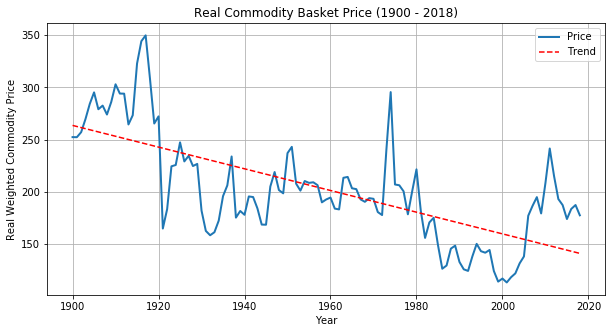

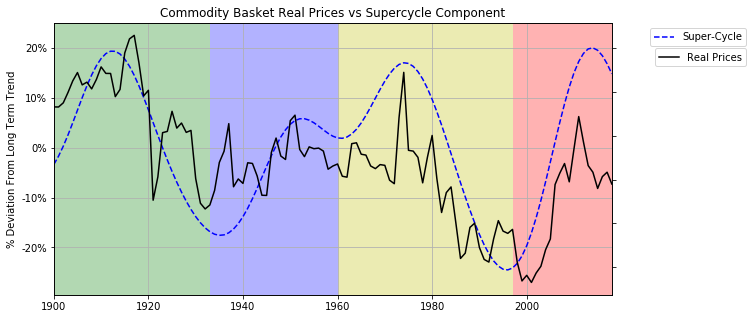

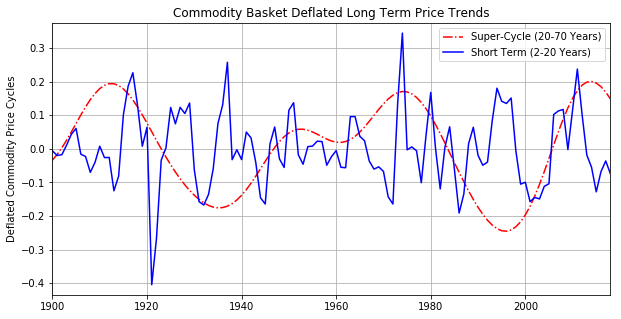

In [27]:
commod_cycle_plot(weight_commod_basket)

# Food Commodity Basket

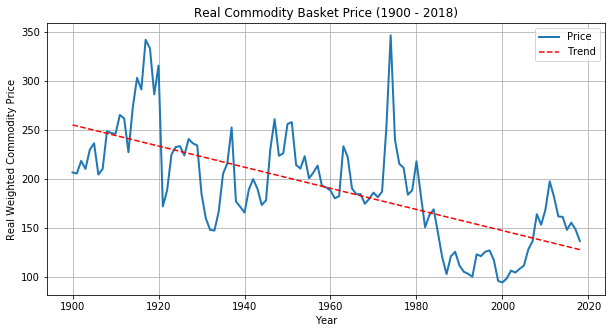

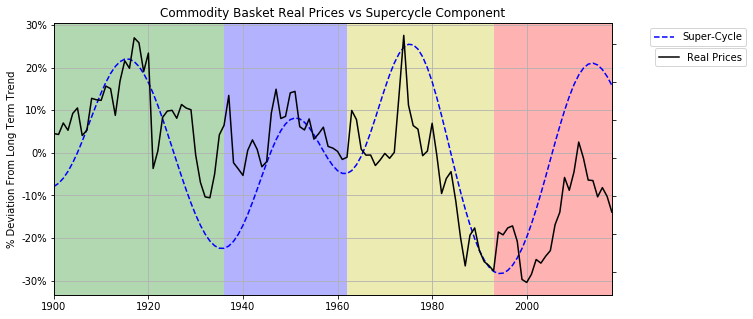

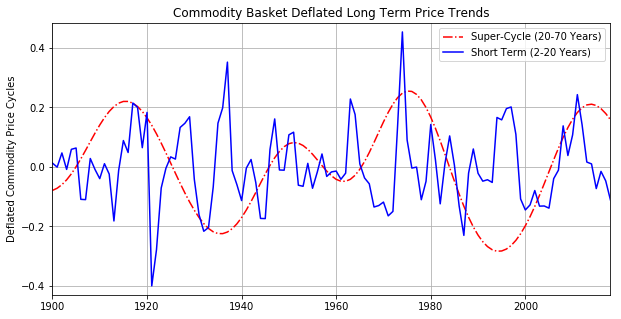

In [28]:
commod_cycle_plot(weight_food_basket)

# Non-Food Commodity Basket

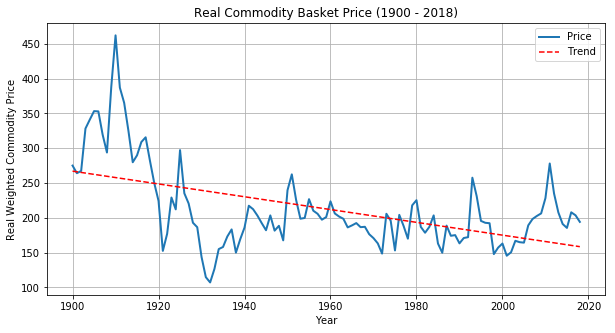

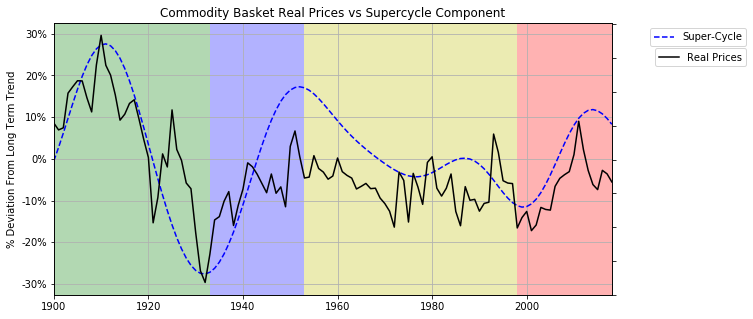

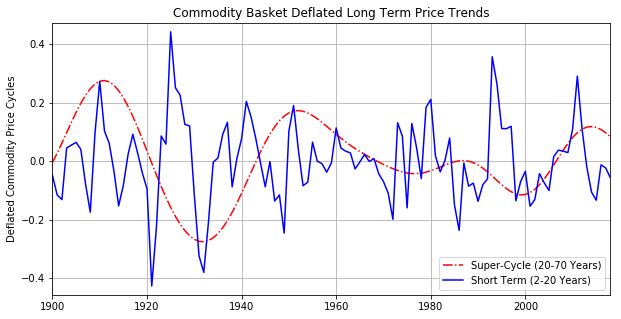

In [29]:
commod_cycle_plot(weight_nonfood_basket)

# Metals Commodity Basket Supercycles

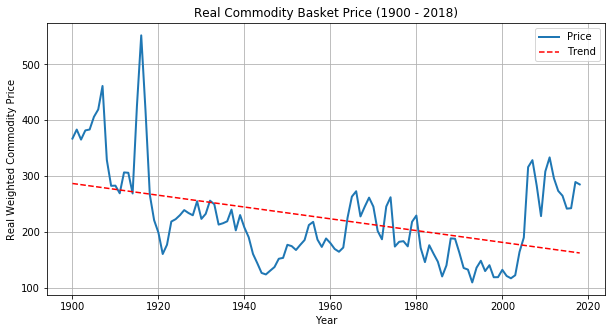

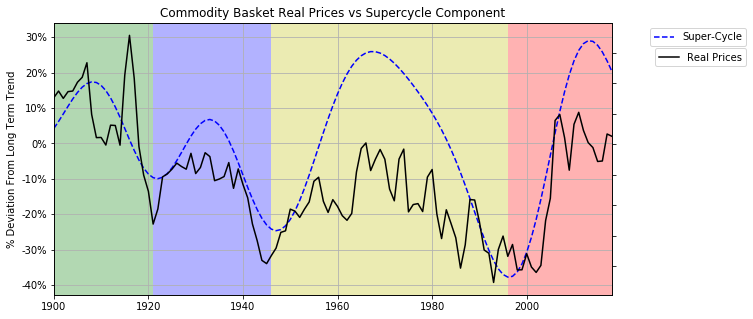

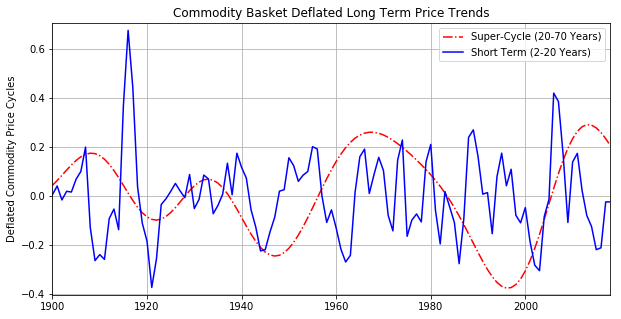

In [30]:
commod_cycle_plot(weight_metals_basket)

# Findings

### We know Commodity Supercycles are coincident with periods of expansion/contraction within global economies...

##### Here are some initial thoughts on each of the cycles. Numbered as follows, 1. Total, 2. Food, 3. Non-Food, 4. Metals

1. The total commodity baskets encompasses the effects of the following 3 baskets of goods. However, the weighting for the basket based on the Grilli-Yang table we reweighted is not equal. It is 58% Food-, 23% Non-Food-, and 19% Metals-driven. This is evident in the Real Prices vs. Supercycle component graphs in both the Total and Food. They are very similar meaning food/agriculture basket was driving the indexed real prices. 
        1.1 - These regions we have defined in the supercycles coincide very well with various macroeconomic expansions and contractions. The first cycle lasting approximently 33 years (shown in green shading) shows the expansion of the United States Industrialization and contraction following World War 1 and subsequent Great Depression. The second region (blue shading) lasting approximently 25 years, shows the recovery and reconstruction of Europe before and after World War 2. The third region (yellow shading) lasting near 40 years, shows the continued recovery of the global economy post World War and the Oil/Energy Shocks of the 1970s (as we know Oil is heavily tied to the Macroeconomic Environment). The final period (red shading) is characterized by the rapid expansion of China beginning in the late 90s and leveling off near present day.

2. The food commodity basket just looks at the 11 food commodities within the total basket weighted in terms of the other commodities within food. The 11 commodities are as follows: Bananas, Beef, Cocoa, Coffee, Lamb, Maize (Corn), Palm Oil, Rice, Sugar, Tea, and Wheat.
        2.1 - As mentioned above, the food supercycles are very similar to the total commodity basket as it accounts for nearly 60% of the weighting. The main difference is the more pronounced contraction during the second region (blue shading) where there was a downtrend most likely associated with the Vietnam War beginning in 1955 and the Cold War reprioritizing resources away from agriculture. 

3. The non-food commodity basket was trimmed from 7 commodities to 4 due to lack of available data on Hides, Jute, and Wool. The commodities we did include were: Cotton, Rubber, Timber, and Tobacco.
        3.1 - The non-food basket shows a few stark differences to the other baskets. First, it has a much shorter supercycle, at or around 20 years which is minimum required, between the Great Depression and the beginning of the Vietnam War. This period of rapid is unlike others as it seems World War 2 did not have a negative effect on the 4 commodities analyzed. The other difference is the strong downtrend during the third (yellow) region. There was a slight upward response to the Energy Crisis in 1979, but the downtrend during this nearly 50 year cycle is clear.

4. The metals commodity basket looks at 6 metals weighted in terms of other metals within the basket. The metals analyzed were: Aluminum, Copper, Lead, Silver, Tin, and Zinc.
        4.1 - The metals basket shows much more similarity to the total commodity basket early in the 20th century than late. From 1900 to 1921 a similar cycle was seen during the US Expansion and concluding with World War 1. After this first cycle, we see clear differences between metals and the other commodities. First, is the clear downtrend during the 2nd region (blue), albeit an increase during the Great Depression, the short lived cyclical peak is match by a sharper downturn concluding in World War 2. However, the other baskets showed a much a near 0 or slightly positive departure from trend during this period whereas metals saw a departure of nearly 25% below trend. The next, and most clear difference is the gold rush and Baby Boomers. As soldiers returned from war they purchased homes with newer technology and with this newer technology came increased metal usage especially Aluminum in vehicles.The last difference is the strong uptick in the last 25 years as Copper becoming increasingly expensive due to its malleability, conductivity, and usefulness. 

# Agriculture Cycles


## Now let's take a closer look at the Agriculture Commodities

##### Cycles do not just have to occur on larger timescales, we will take a closer look at 2 - 5 year cycles within the food basket.

We will be doing agriculture cycles for the total basket and each of the 11 individual commodities within the food basket. The cyclical period we chose was to represent annual row crops (corn, soybeans, etc.) at 2 year periods and tree crops (cocoa, coffee, etc.) at 5 years. 

This process is very similar to the last one just a different low and high pass on the Band-Pass Filter on each element.

In [31]:
def agcycle_plot(food_basket,total=True):
    '''
    This function will take in a weighted basket of agriculture commodities and output a plot of the components of its cyclical
    nature from periods of 2 to 5 years.
    
    There will be 2 graphs for each commodity basket. The first shows the downward trend in price over time.
    The second compares the natural log of the price to the agriculture cycle component. The second will compare the agriculture 
    cycle (2 - 5 years) component to the supercycle (20 - 70 years) component in terms of deviation from long-term 
    trend (70+ years).
    
    INPUT:
    
    food_basket - dataframe of real indexed agricultural commodity prices. Changed to real using Manufacturing Unit Value 
    deflator and multiplied by the Grilli-Yang Sub-Indices.
    
    total (bool) - If True, gives total agriculutre cycle for combined food_basket, plots are the prices and trend and ag cycle
    for total basket. If false, it will give the ag-cycle for each commodity within food_basket dataframe and plot versus prices 
    deviation from long-term trend.
    
    OUTPUT:
    
    2 plots:
    
    1. Original summed real price series to show down trend in commodity prices.
    
    2. Ln_price versus the agricultural cycle
    '''
    x=np.arange(1900,2019) # Defining x because it won't let me use index of sum_commod for some reason...
    col_list = food_basket.columns.tolist()
    if total == True:
        # Sum the commodity basket series for each given year and plot to see downtrend (shown as dashed red line for simiplicity)
        sum_commod = food_basket.sum(axis=1)
        
        fig, ax1 = plt.subplots(figsize=(10,5))
        ax1.plot(x, sum_commod.values,linewidth=2);
        ax1.set_xlabel('Year');
        ax1.set_ylabel('Real Weighted Commodity Price');
        ax1.set_title('Real Commodity Basket Price (1900 - 2018)');
        z = np.polyfit(x, sum_commod.values, 1);
        p = np.poly1d(z);
        plt.plot(x, p(sum_commod.index),'r--');
        plt.legend(['Price','Trend'],loc='upper right');
        plt.grid(b=True);
        # Take natural log to detrend and plot
        ln_price = np.log(sum_commod)
    
        # Utilize Band-Pass Filter from  Christiano and Fitzgerald (2003 Paper)
        ag_cycle, ag_trend = cffilter(ln_price.values, low=2, high=5, drift=False)
        
        fig2, ax2 = plt.subplots(figsize=(10,5))
        ax2.plot(x, ag_cycle, 'b--');
        ax2.yaxis.set_major_formatter(PercentFormatter(xmax=1));
        ax2.set_ylabel('% Deviation From Long Term Trend');
        plt.grid(b=True);
        plt.legend(['Ag-Cycle'],loc=0,bbox_to_anchor=(.75,.5,.5,.5));
        ax3 = ax2.twinx()
        ax3.plot(x, ln_price.values,'k');
        ax3.yaxis.set_major_formatter(NullFormatter());
        plt.legend(['Real Prices'],loc=0,bbox_to_anchor=(.75,.425,.5,.5));
        plt.title('Total Commodity Basket Real Prices vs Agriculture Cycle Deviation From Trend');
        ax3.set_xlim((1900,2018));
        plt.show()
        print('The max positive deviation from trend by the Agriculture cycle is: {:.2%}\n'.format(np.max(ag_cycle)))
        print('The max negative deviation from trend by the Agriculture cycle is: {:.2%}'.format(np.min(ag_cycle)))
        
    else:
        for col in range(len(col_list)):
            fig, axs = plt.subplots(figsize=(10,5))
            fig2, axs2 = plt.subplots(figsize=(10,5))
            axs.plot(x, food_basket.iloc[:,col].values,linewidth=2);
            axs.set_xlabel('Year');
            axs.set_ylabel('{} Weighted Commodity Price'.format(col_list[col].title()));
            axs.set_title('{} Commodity Basket Price (1900 - 2018)'.format(col_list[col].title()));
            plt.grid(b=True);
            # Take natural log to detrend and plot
            ln_price = np.log(food_basket.iloc[:,col])

            ag_cycle, ag_trend = cffilter(ln_price.values, low=2, high=5, drift=False)


            axs2.plot(x, ag_cycle, 'b--');
            axs2.yaxis.set_major_formatter(PercentFormatter(xmax=1));
            axs2.set_ylabel('% Deviation From Long Term Trend');
            axs2.set_ylim((-.5,.5))
            plt.grid(b=True);
            plt.legend(['Ag-Cycle'],loc=0,bbox_to_anchor=(.75,.5,.5,.5));
            axs3 = axs2.twinx()
            axs3.plot(x, ln_price.values,'k');
            axs3.yaxis.set_major_formatter(NullFormatter());
            plt.legend(['Real Prices'],loc=0,bbox_to_anchor=(.75,.425,.5,.5));
            plt.title('{} Prices vs {} Agriculture Cycle Deviation'.format(col_list[col].title(),col_list[col].title()));
            axs3.set_xlim((1900,2018));
            plt.show()
            print('The max positive deviation from trend by the {} Agriculture cycle is: {:.2%}\n'.format(col_list[col].title(),
                                                                                                        np.max(ag_cycle)))
            print('The max negative deviation from trend by the {} Agriculture cycle is: {:.2%}\n'.format(col_list[col].title(),
                                                                                                        np.min(ag_cycle)))
            print('----------------------------------------------------------------------------------------------------\n')
            
            
        
        

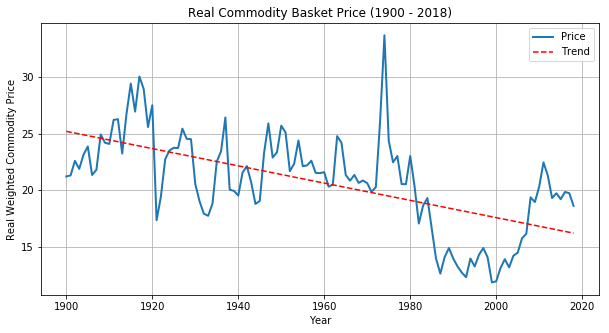

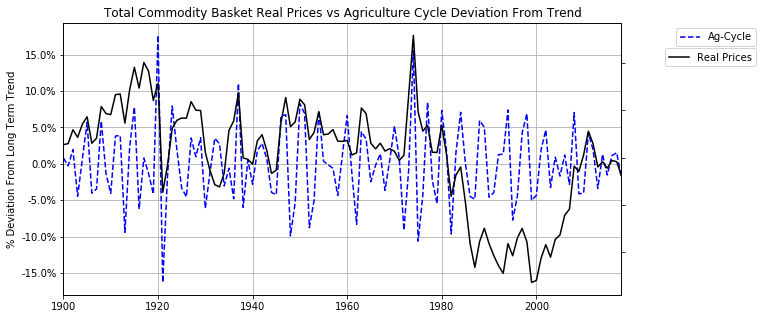

The max positive deviation from trend by the Agriculture cycle is: 17.67%

The max negative deviation from trend by the Agriculture cycle is: -16.32%


In [32]:
agcycle_plot(food_basket,total=True)

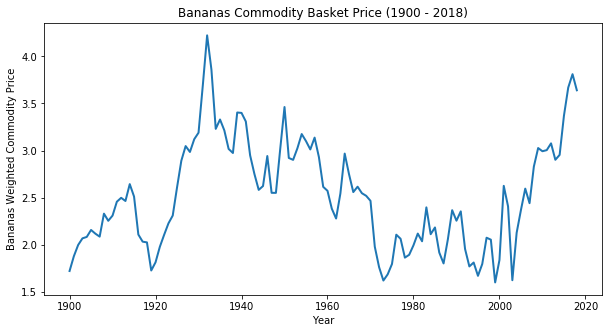

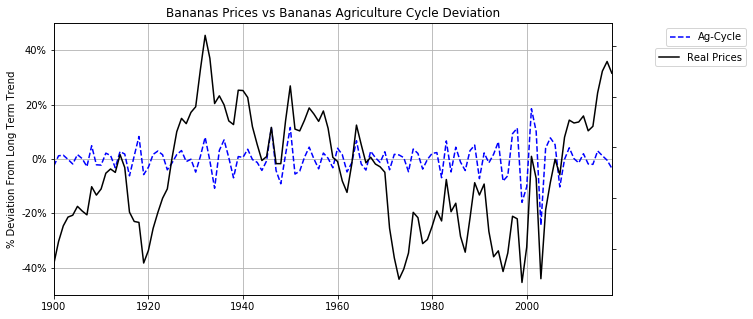

The max positive deviation from trend by the Bananas Agriculture cycle is: 18.46%

The max negative deviation from trend by the Bananas Agriculture cycle is: -24.40%

----------------------------------------------------------------------------------------------------



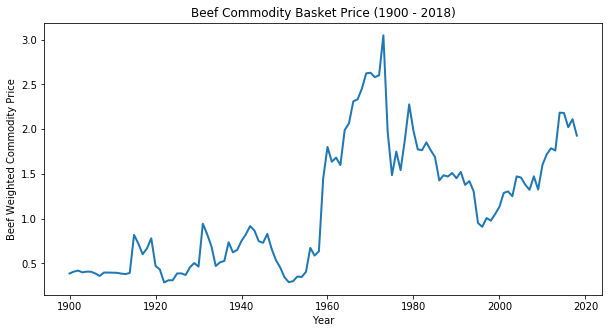

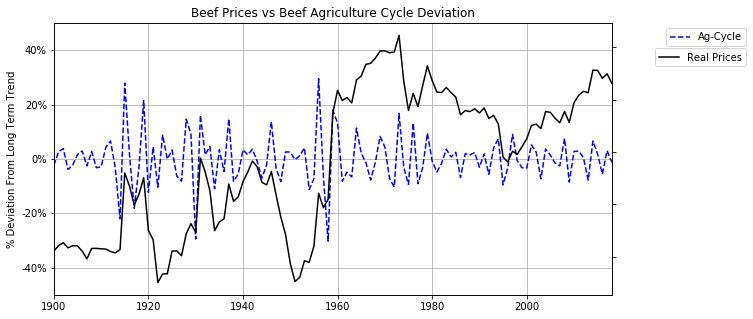

The max positive deviation from trend by the Beef Agriculture cycle is: 29.51%

The max negative deviation from trend by the Beef Agriculture cycle is: -30.26%

----------------------------------------------------------------------------------------------------



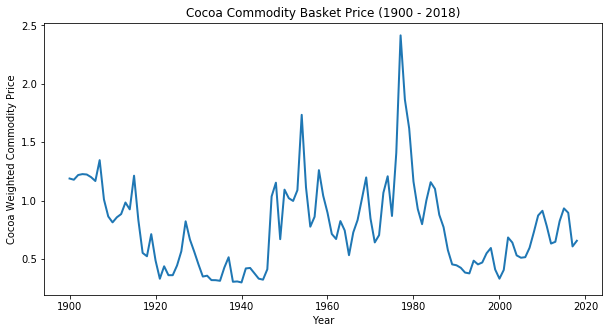

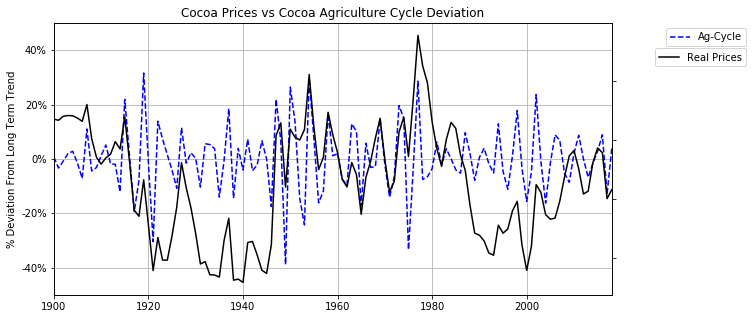

The max positive deviation from trend by the Cocoa Agriculture cycle is: 31.61%

The max negative deviation from trend by the Cocoa Agriculture cycle is: -38.86%

----------------------------------------------------------------------------------------------------



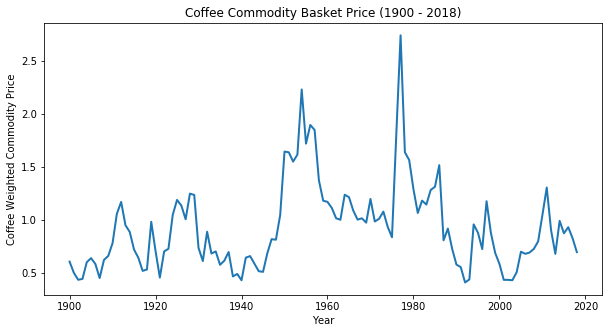

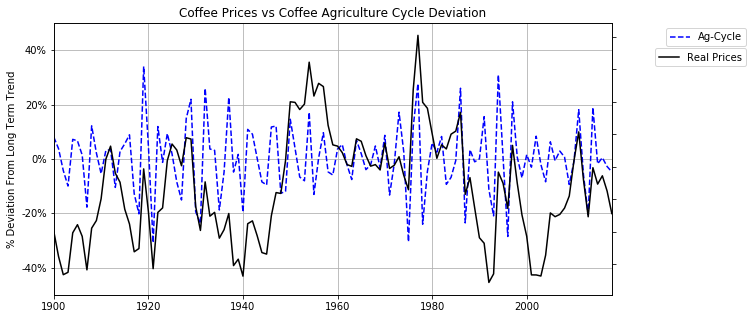

The max positive deviation from trend by the Coffee Agriculture cycle is: 34.01%

The max negative deviation from trend by the Coffee Agriculture cycle is: -30.85%

----------------------------------------------------------------------------------------------------



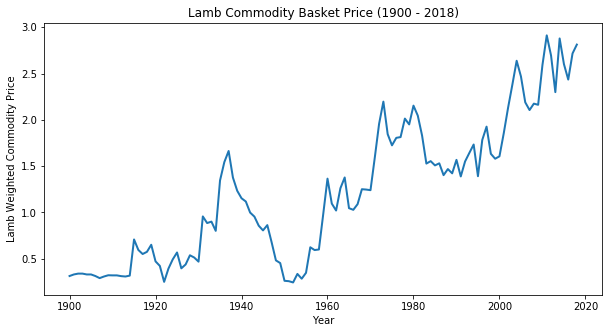

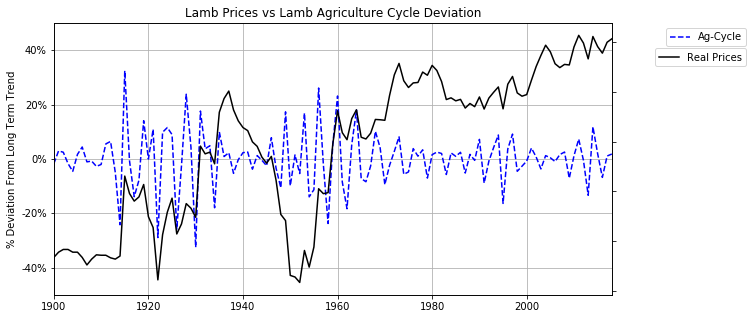

The max positive deviation from trend by the Lamb Agriculture cycle is: 32.43%

The max negative deviation from trend by the Lamb Agriculture cycle is: -32.53%

----------------------------------------------------------------------------------------------------



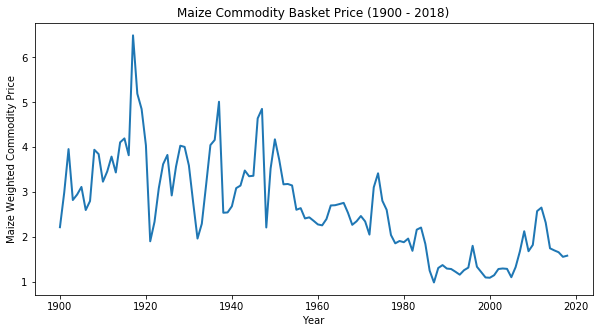

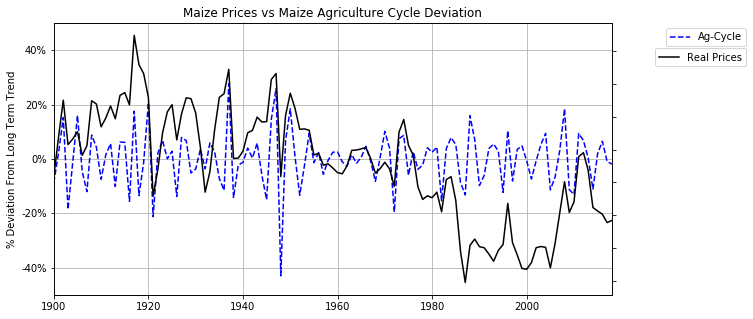

The max positive deviation from trend by the Maize Agriculture cycle is: 27.65%

The max negative deviation from trend by the Maize Agriculture cycle is: -43.03%

----------------------------------------------------------------------------------------------------



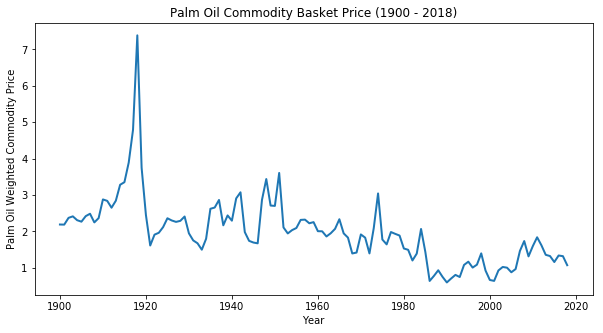

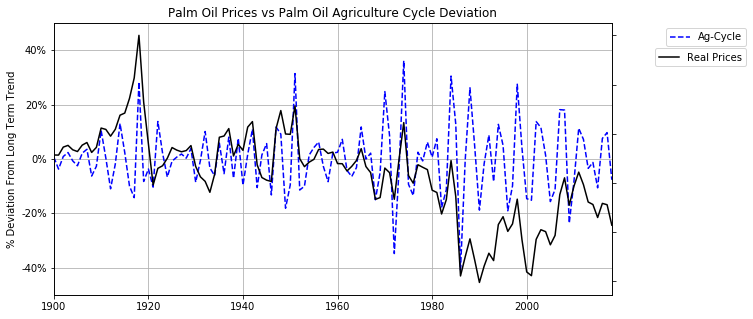

The max positive deviation from trend by the Palm Oil Agriculture cycle is: 36.12%

The max negative deviation from trend by the Palm Oil Agriculture cycle is: -40.88%

----------------------------------------------------------------------------------------------------



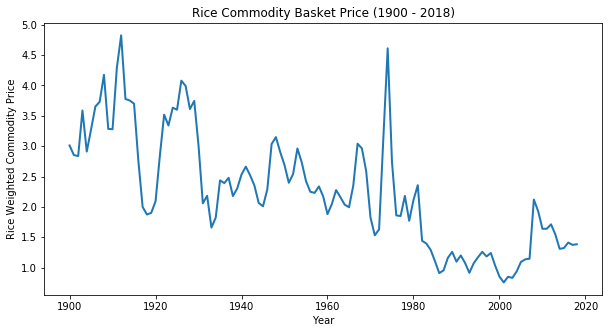

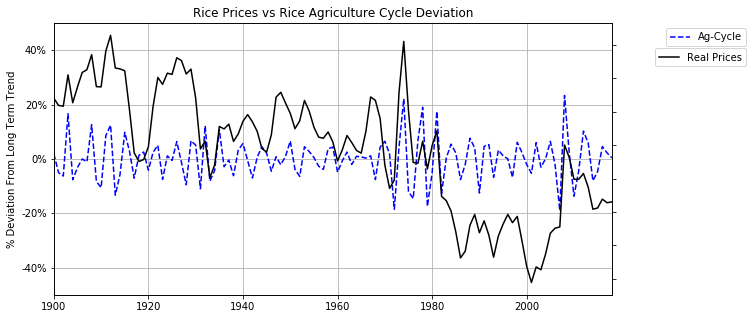

The max positive deviation from trend by the Rice Agriculture cycle is: 23.36%

The max negative deviation from trend by the Rice Agriculture cycle is: -19.06%

----------------------------------------------------------------------------------------------------



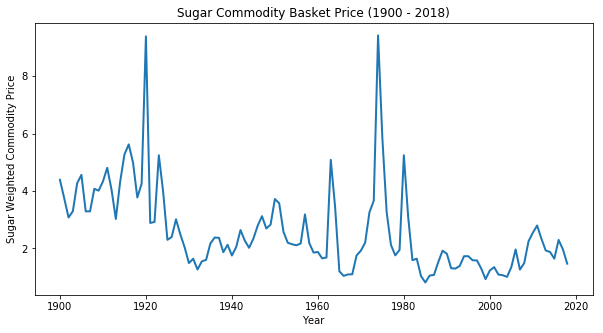

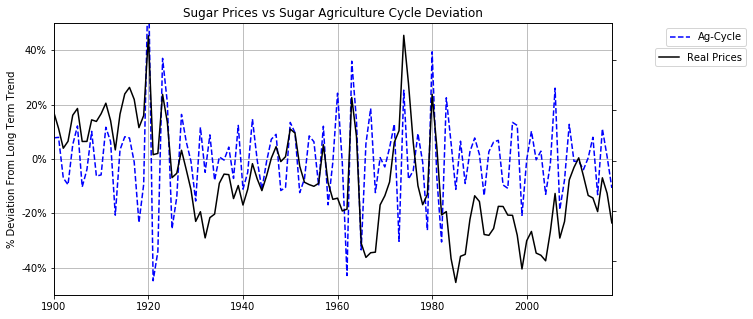

The max positive deviation from trend by the Sugar Agriculture cycle is: 69.70%

The max negative deviation from trend by the Sugar Agriculture cycle is: -44.82%

----------------------------------------------------------------------------------------------------



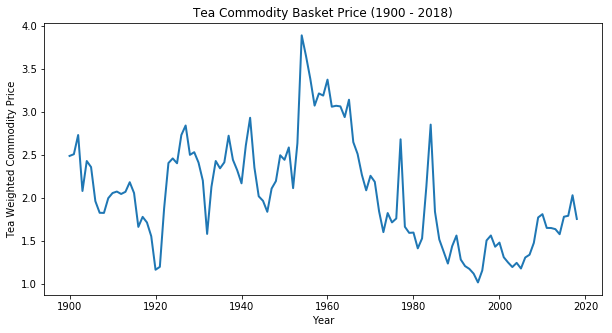

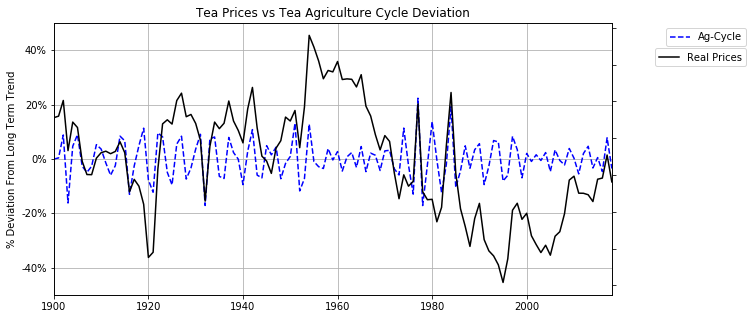

The max positive deviation from trend by the Tea Agriculture cycle is: 22.33%

The max negative deviation from trend by the Tea Agriculture cycle is: -17.17%

----------------------------------------------------------------------------------------------------



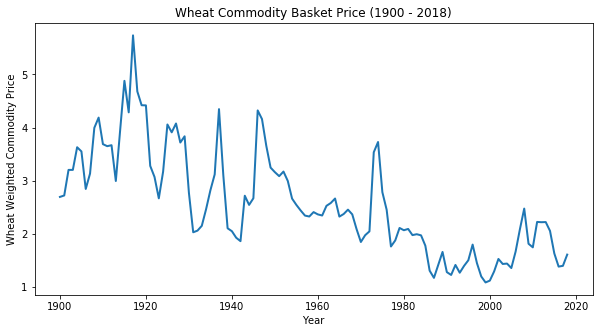

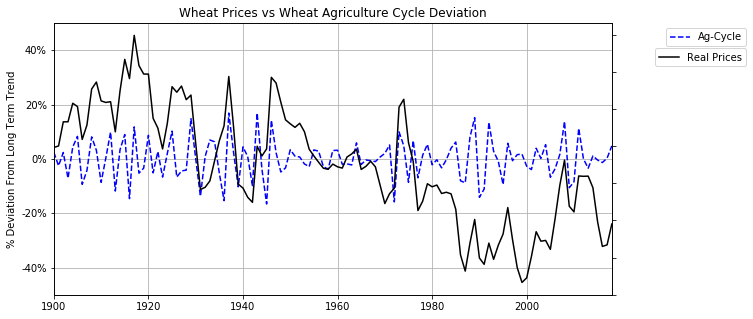

The max positive deviation from trend by the Wheat Agriculture cycle is: 16.87%

The max negative deviation from trend by the Wheat Agriculture cycle is: -16.59%

----------------------------------------------------------------------------------------------------



In [33]:
agcycle_plot(food_basket,total=False)

# Findings

### Agriculture Cycle highlight the cyclical nature of agriculture

Like the image above highlighting supercycle theory in terms of expansion/contraction of large economies, agriculutre follows a similar cycle between supply and demand for the product.

<img src="ag_cycle.png"/>

Agriculture cycles are functions of Supply and Demand. Each of the arrows above are explained below beginning from supply shock in lower left.

1. Supply Shock - Increased prices in market as supply is constrained from one or more external factors such as poor weather,  government interaction, etc. 

2. Supply Incentive - This increase in prices incentivized farmers to plant more for the following season, thus increasing available supply assuming constant weather. 

3. Peak Price - The peak of a rally where the increased supply is able to meet or even slightly exceed demand. Prices will begin to fall from here once new supply/demand relationship is realized within market.

4. Demand Rationing - As increased supply continues to exceed demand it begins to heavily weigh on price. This occurs as stocks of the commodity are built as consumption cannot meet supply.

5. Supply Disincentive - Prices begin to level off as farmers will begin to hold back or even convert farms to different (more profitable) crops rather than those oversupplied to market. This will edge the balance of supply and demand closer to even.

6. Base Prices - Prices have reached the bottom as supply has fallen enough to meet suppressed demand. Fundamentally, prices will remain here until another Supply Shock occurs offsetting the balance of Supply/Demand.

### Notable Supply Shocks

##### 1. Bananas - Gros Michel Banana ravaged by disease in 40s and 50s leading to replacement of Cavendish Banana

See the spike in the agricultural cycle indicating the lack of supply of Gros Michel (upward price pressure) and resupply of Cavendish, a disease-resistant banana variant, (downward price pressure).

##### 2. Rice - 2007 Farm Crisis and 2008 - 2013 Record Profits

Poor harvests, increased consumption, and biofuels (addition supply constrain) lead to prices of Rice spiking considerably in late 2007. Lower-income families could no longer afford rice and developed countries exported Rice for incredible profits for next 5 years.

##### 3. Corn/Wheat - 1970's Oil Shock

The oil crisis in conjunction with droughts and massive Russian imports of Grains, caused grains prices to increase rapidly in the mid 70's. We see around 1973 when both of their ag-cycles reach a peak coinciding with a peak in the real prices.

# Conclusion and Improvements

## Conclusions

Super-cycles: 

1. What are the super cyles within that last 120 years?
    
    - Since we defined super cycles as they did in the paper, [Super-cycles of commodity prices since the mid-nineteenth century](https://www.un.org/esa/desa/papers/2012/wp110_2012.pdf), we saw 4 distinct supercycle periods in all 4 of the commodity baskets.

2. What defines the super cycles during these periods?
    
    - While the exact time periods vary, it seems to show the US expansion before WW1 as the first cycle, Europe's reconstruction and WW2 as the second, the expanding Global Economy mixed with shorter term events such as wars and oil crisis as the third, and China's rapid industrialization and expansion as the fourth.

Ag-Cycles:

1. Are there commodities which have a similar length of cycle?
    
    - See improvements section on attacking this with Fourier Transforms in future. But, by looking at these graphs you can see some similarities in row crops (or those that feed off row crops such as Beef or Lamb) have a generally shorter cycle (2-3 years) than the tree crops (cocoa, coffee, palm oil, etc.) which are about 4-6 years on average.
    
2. Are notable Supply Shocks (1970s Oil Crisis, 2007 Farm Crisis, etc.) able to be seen coincidentally as a peak in the ag-cycle component?

    - As stated above in findings, there are a few noted especially on Oil and Farm Crisis. There is also one about the migration from the Gros Michel Banana to the Cavendish which was the cause of its ag-cycle and price spike around 1950.
    
## Improvements

1. With Super-cycles, make the entire process a function so it can be callable and give more personalized information to stakeholders when they want to know what next instance of commodity supercycle they are in. 

2. More dynamic shading of the super cycle regions, currently hard-coded through trial and error.

3. With Ag-cycles figure out a method to find maximum, minimum, and average period of cycle rather than estimating by looking at the charts

4. Use number 3 to make better conclusions about how the agriculture cycles reflect back on price and vice-versa.